In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import  accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline

In [2]:
data = pd.read_csv('train.csv')

In [3]:
test_data = pd.read_csv('test.csv')

### EDA

In [4]:
data.head(5)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
data.shape

(165034, 14)

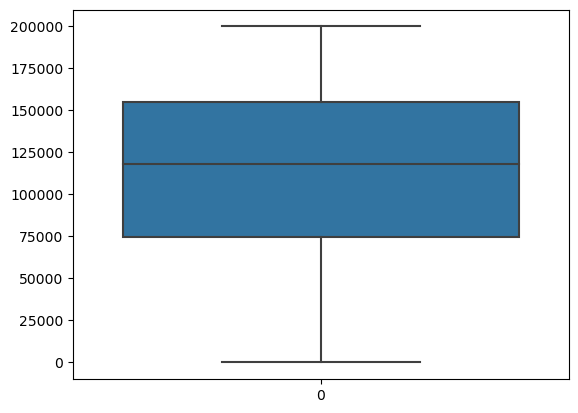

In [5]:
sns.boxplot(data['EstimatedSalary']);

<Axes: >

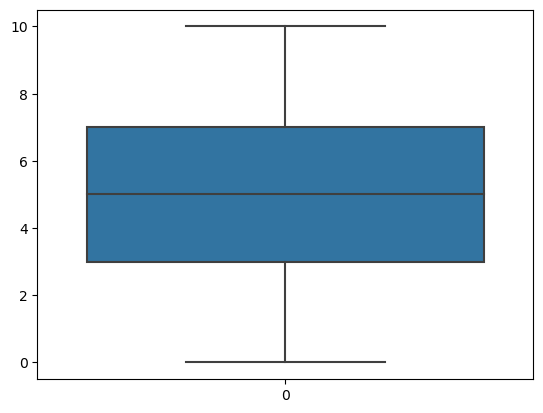

In [6]:
sns.boxplot(data['Tenure'])

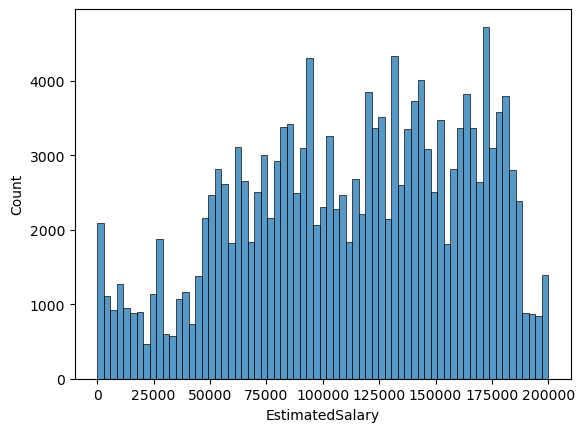

In [7]:
sns.histplot(data['EstimatedSalary']);

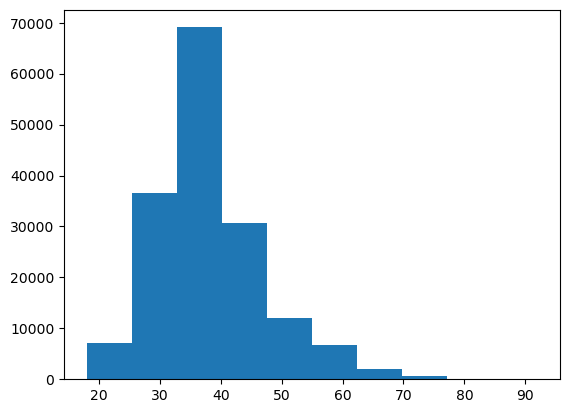

In [8]:
plt.hist(data['Age']);

In [9]:
Age_Est= data[['Age', 'EstimatedSalary']]


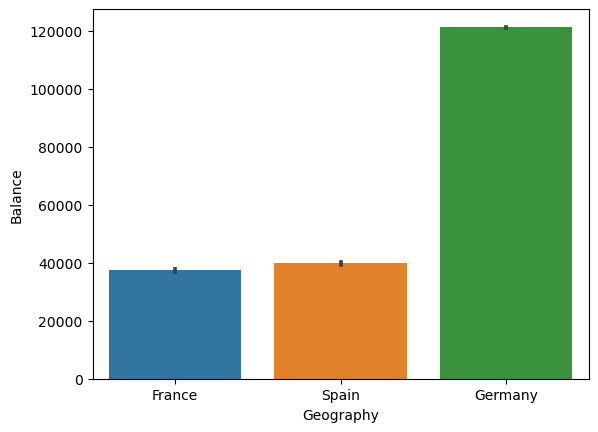

In [10]:
sns.barplot(data, x=data['Geography'], y = data['Balance']);

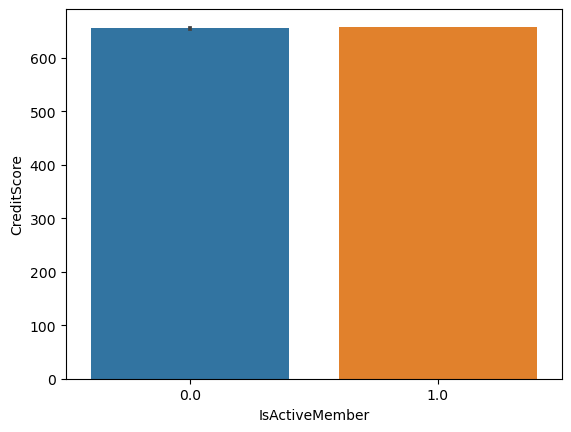

In [11]:
sns.barplot(data, x=data['IsActiveMember'], y = data['CreditScore']);

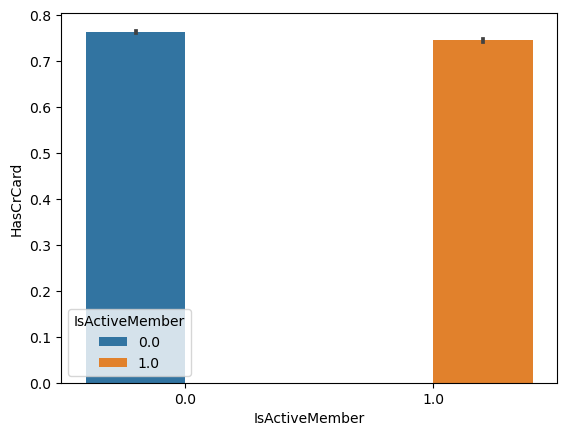

In [12]:
sns.barplot(data, x=data['IsActiveMember'], y = data['HasCrCard'], hue='IsActiveMember');

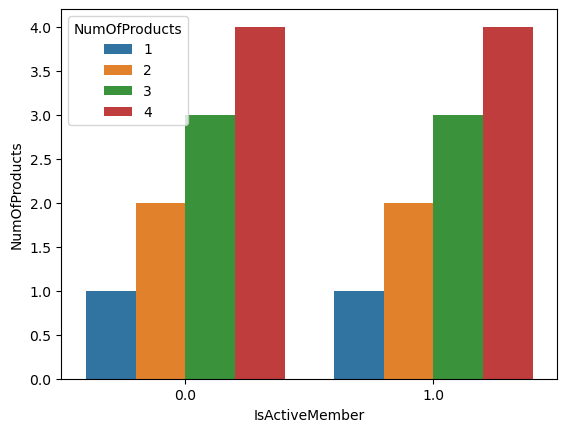

In [13]:
sns.barplot(data, x=data['IsActiveMember'], y = data['NumOfProducts'], hue='NumOfProducts');

In [14]:
data[['Surname', 'Balance', 'Tenure']].sort_values(by=['Tenure','Balance'], ascending =False).head(10).reset_index(drop=True)

,Surname,Balance,Tenure
0,Kirillova,238387.56,10
1,Yermakov,207034.96,10
2,Coates,206663.75,10
3,Kang,201696.07,10
4,Napolitano,200724.96,10
5,Mello,200724.96,10
6,Napolitano,200724.96,10
7,Napolitani,200724.96,10
8,Napolitani,200724.96,10
9,Napolitani,200724.96,10


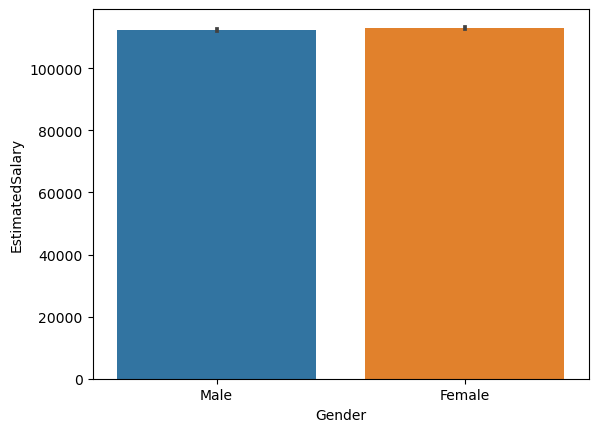

In [15]:
sns.barplot(data, x=data['Gender'], y = data['EstimatedSalary']);

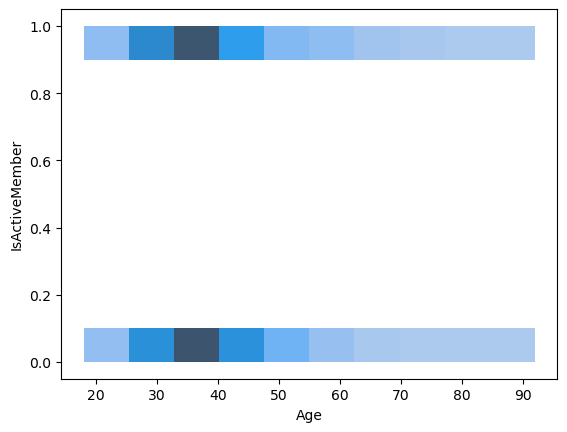

In [16]:
sns.histplot(data, x=data['Age'], y=data['IsActiveMember'], bins=10);

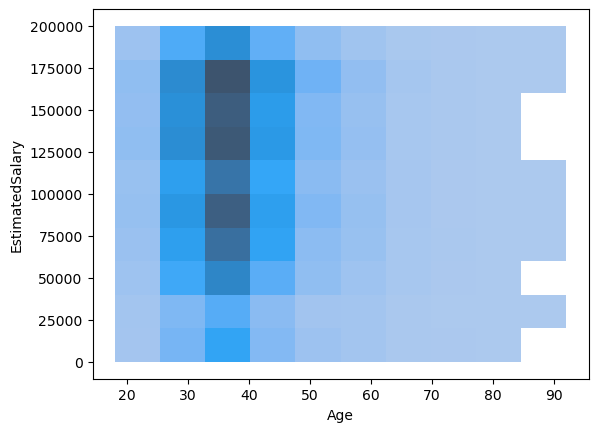

In [17]:
sns.histplot(data, x=data['Age'], y=data['EstimatedSalary'], bins=10);

In [18]:
data[['Age', 'Gender', 'EstimatedSalary']].sort_values(by="EstimatedSalary", ascending=False).head(20).T

,115773,84881,136835,126931,31730,72582,105249,122175,102777,64645,45604,44559,60591,115444,133970,46834,11878,15308,92504,9645
Age,42.0,36.0,42.0,42.0,42.0,41.0,35.0,41.0,46.0,35.0,44.0,44.0,28.0,42.0,42.0,42.0,38.0,37.0,42.0,33.0
Gender,Female,Male,Female,Female,Female,Male,Female,Female,Male,Female,Male,Female,Female,Female,Female,Female,Female,Female,Female,Female
EstimatedSalary,199992.48,199992.48,199992.48,199992.48,199992.48,199992.48,199992.48,199992.48,199992.48,199992.48,199992.48,199992.48,199992.48,199992.48,199992.48,199992.48,199992.48,199992.48,199992.48,199992.48


### Preprocessing

In [19]:
data['CreditScoreBalance']= data['CreditScore'] * data['Balance']

In [20]:
data['CreditScore/Age'] = data['CreditScore'] / data['Age']

In [21]:
data['AgeAtBank'] = data['Age'] - data['Tenure'] 

In [22]:
def drop_id(df_input):
    df_input = df_input.drop(columns = 'id', axis = 1)
    return df_input

df = drop_id(data)
df.head(5)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScoreBalance,CreditScore/Age,AgeAtBank
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0.00,20.242424,30.0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0.00,19.000000,32.0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0.00,16.950000,30.0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,86500755.74,17.088235,32.0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0.00,21.696970,28.0


In [23]:
test_df = drop_id(test_data)

test_df['CreditScoreBalance']= test_df['CreditScore'] * test_df['Balance']
test_df['CreditScore/Age'] = test_df['CreditScore'] / test_df['Age']
test_df['AgeAtBank'] = test_df['Age'] - test_df['Tenure'] 

In [24]:
X = df.drop(columns=["Exited"],axis=1)
y = df["Exited"]

In [25]:
num_data_SC = ["Age", "EstimatedSalary", "Balance", "CreditScore", "CreditScoreBalance", "CreditScore/Age", "AgeAtBank"]
cat_data_OHE = ["Geography", "Gender", "IsActiveMember", "NumOfProducts", "HasCrCard", "Tenure"]
cat_data_OE = ["CustomerId","Surname"]

transform_num_SC = StandardScaler()
transform_cat_data_OHE = OneHotEncoder()
transform_cat_data_OE = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

processor = ColumnTransformer(
    transformers = [
        ("num", transform_num_SC, num_data_SC),
        ("cat_OHE", transform_cat_data_OHE, cat_data_OHE),
        ("cat_OE", transform_cat_data_OE, cat_data_OE)
                    ]
)


In [26]:
trans_X = processor.fit_transform(X)
X_test = processor.transform(test_df)

In [29]:
models = [
    ('CatBoost Classifier', CatBoostClassifier(iterations=1000, verbose=0)),
    ('LGBMClassifier', LGBMClassifier()),
    ('XGBoost Classifier', XGBClassifier()),
    ('Random Forest Classifier', RandomForestClassifier()),
    ('Extra Trees Classifier', ExtraTreesClassifier())
]


pipelines=[]

for name, model in models:
    pipeline= make_pipeline(StandardScaler(), model)
    pipelines.append((name,pipeline))
    
# Create the ensemble model
ensemble = VotingClassifier(estimators= pipelines, voting = 'soft')

cross_val = cross_val_predict(ensemble, trans_X, y, cv=5, method='predict_proba')

roc_auc = roc_auc_score(y, cross_val[:, 1])

# Print the result
print(f"Ensemble ROC AUC: {roc_auc}")

[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] Start training from score -1.315304
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2002
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 33
[LightGBM] [In

In [30]:
# Define the parameters 
params = {
    'weights': [
                [2, 2, 2, 1, 1],  # hypothetical better combinations according to models' AUC
                [2, 2, 2, 2, 1]   
               ]
}
    
grid_search = GridSearchCV(ensemble, param_grid=params, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

grid_search.fit(trans_X, y)

grid_search.best_params_

grid_search.best_estimator_

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[LightGBM] [Info] Number of positive: 34921, number of negative: 130113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2004
[LightGBM] [Info] Number of data points in the train set: 165034, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211599 -> initscore=-1.315315
[LightGBM] [Info] Start training from score -1.315315


VotingClassifier(estimators=[('CatBoost Classifier',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('catboostclassifier',
                                               <catboost.core.CatBoostClassifier object at 0x000002E092180910>)])),
                             ('LGBMClassifier',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('lgbmclassifier',
                                               LGBMClassifier())])),
                             ('XGBoost Classifier',
                              Pipeline(steps=[('standardscal...
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...))])),
                             ('Random Forest Classifier',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('randomforestclassifier',
                                               RandomForestClassifier())])),
                             ('Extra Trees Classifier',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('extratreesclassifier',
                                               ExtraTreesClassifier())]))],
                 voting='soft', weights=[2, 2, 2, 1, 1])

In [33]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

predictions = best_model.predict_proba(X_test)[:, 1]
predictions

array([0.01770427, 0.88057068, 0.02251732, ..., 0.01501968, 0.16609633,
       0.18054832])

In [34]:
submission = pd.read_csv("sample_submission.csv")
submission

,id,Exited
0,165034,0.5
1,165035,0.5
2,165036,0.5
3,165037,0.5
4,165038,0.5
...,...,...
110018,275052,0.5
110019,275053,0.5
110020,275054,0.5
110021,275055,0.5


In [35]:
submission["Exited"] = predictions

In [36]:
submission.to_csv("best_submission.csv", columns = submission.columns, index = False)
submission.head(10)

,id,Exited
0,165034,0.017704
1,165035,0.880571
2,165036,0.022517
3,165037,0.213526
4,165038,0.369634
5,165039,0.048787
6,165040,0.031112
7,165041,0.080025
8,165042,0.621327
9,165043,0.006831
